<a href="https://colab.research.google.com/github/MarkStephens060482/WildFires/blob/master/Wildfire_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive modelling of Wildfires

A dataset based on Remote Sensing data related to the state of the crops (NDVI), meteorological conditions (LST), as well as the fire indicator “Thermal Anomalies”, these data, were acquired from “MODIS” (Moderate Resolution Imaging Spectroradiometer), a key instrument aboard the Terra and Aqua satellites. This dataset is available on GitHub via this link (https://github.com/ouladsayadyounes/Wildfires). The study area is composed of multiple zones located in the center of Canada.

The Dataset:

|Variables| Description|Type|
|:-------:|:----------:|:--:|
|NDVI| Normalised Difference Vegetation Index: indicates the state of crop health, it can be used to assess spatiotemporal changes in green vegetation.| *Float*|
|LST| Land Surface Temperature: represents the radiative skin temperature of land surface derived from solar radiation, depends on vegetation cover and th soi moisture.| Float|
|Burned_Area|


In [8]:
# importing libraries
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

In [4]:
#loadiong the dataset from GitHub
url = "https://raw.githubusercontent.com/MarkStephens060482/WildFires/master/WildFires_DataSet.csv"
data = pd.read_csv(url)

In [5]:
data.head()

,NDVI,LST,BURNED_AREA,CLASS
0,0.506782,14584.272727,4.692308,no_fire
1,0.522150,14655.833333,5.000000,no_fire
2,0.682284,14780.000000,5.000000,fire
3,0.120046,13298.500000,3.500000,no_fire
4,0.568734,14743.000000,5.000000,no_fire


### Pairplot
The numerical variables considered as possible predictors are examined, excluding *NDVI*, *LST* and *BURNED_AREA*. 

Text(0.5, 1.03, 'Pair p;ot of numerical predictors')

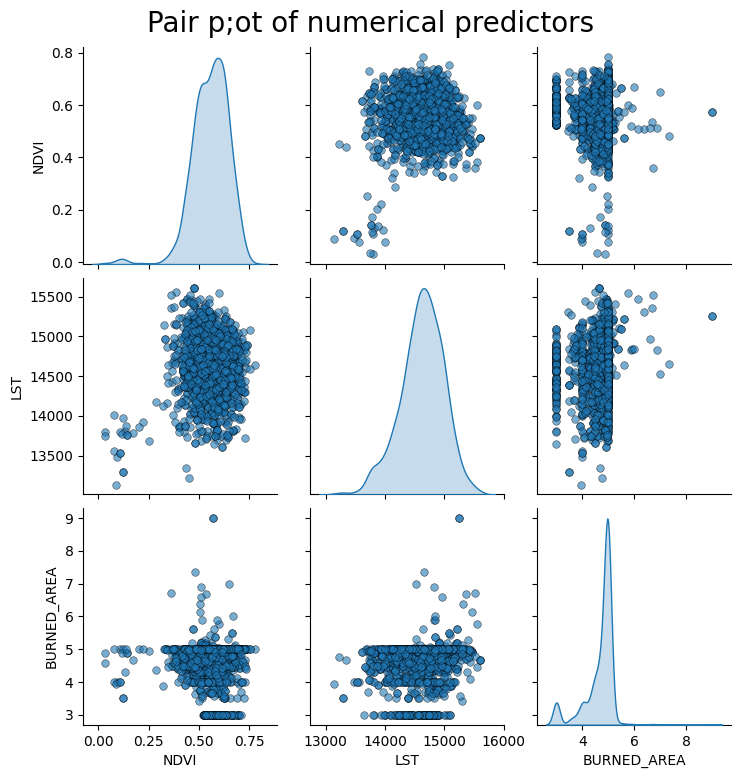

In [10]:
sns.pairplot(data,
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}
             )         
  # Title 
plt.suptitle(f'Pair p;ot of numerical predictors',
             size = 20,
             y=1.03)         

Classification models ployed in ensemble model for wildfire classification using scikit-learn library.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

#model predictors
X = data.drop('CLASS', axis=1) 

#target variable
y = data['CLASS']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define a minmax scaler to normalise minmax
minmax = MinMaxScaler()

# Create a pipeline for data preprocessing
preprocessor = make_pipeline(minmax)

# Target encoding
le = LabelEncoder()

# Transform Target variable by encoding
le.fit_transform(y)


#create individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
nb = GaussianNB()
rbfsvc = SVC(kernel = "rbf",random_state=42)
mlp = MLPClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

vc = VotingClassifier([('dt', DecisionTree), 
                       ('KNN', KNN), 
                       ('MLPC', MLPC), 
                       ('rf', RandomForest), 
                       ('xgb', XGB)],
                      njobs = -1)


# define the pipeline for Support Vector Machine Regression.
pipeline_svr = make_pipeline(preprocessor, regressor_svr)

#### Dummy Regressor
Use a 'mean' strategy to establish a baseline for model performance.

In [16]:
from sklearn.dummy import DummyRegressor
# initiialise the dummy regressor
regressor_dummy = DummyRegressor(strategy='mean')
#develop a pipeline model for the dummy regressor
pipeline_dummy = make_pipeline(regressor_dummy)